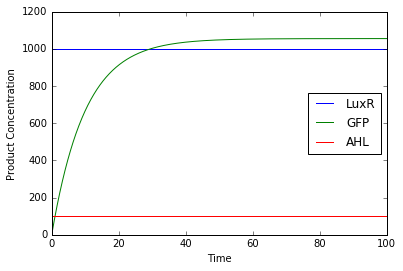

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import least_squares

# define your modules
def pLux1(LuxR, AHL):
    # This is the module for a specific insubstatiation of a lux promoter
    # the input is a LuxR amount and an AHL amount
    # the output is a protein production amount
    
    # For every promoter there is some function that determines what the promoter's
    #     maximal and basal expression is based on the amount of transcriptional factor
    #     is floating around in the cell. These numbers are empircally determined, and
    #     for demonstration purposes are fictionally and arbitrarily filled in here. 
    #     These functions take the form of hill functions.
    basal_expression = 1 + (5 * (LuxR / (LuxR + 10))) # low LuxR gives basal of 1, high LuxR gives basal of 6
    maximal_expression = 10 + (100 * (LuxR / (LuxR + 5))) # Low LuxR gives max of 10, high LuxR gives max of 110
    Kd = 10
    
    protein_production_from_pLux = basal_expression + maximal_expression*(AHL / (Kd + AHL)) 
    
    return protein_production_from_pLux

def simulation_set_of_equations(y, t, *args):
    # Args are strictly for parameters we want to eventually estimate.
    # Everything else must be hardcoded below. Sorry for the convience. 
    
    # Unpack your parameters
    k_pCon_express = args[0] # A summation of transcription and translation from a pCon promoter
    k_pLux_express = args[1] # A summation of transcription and translation from a pLux promoter
    k_loss = args[2] # A summation of dilution and degredation
    
    # Unpack your current amount of each species
    LuxR, GFP, AHL = y
    
    # Determine the change in each species
    dLuxR = k_pCon_express - k_loss*LuxR
    dGFP = pLux1(LuxR, AHL) - k_loss*GFP
    dAHL = 0 # for now we're assuming AHL was added exogenously and never degrades
    
    # Return the change in each species
    # scipy.odeint will take these values and apply them to the current value of each species in the next time step for you
    return [dLuxR, dGFP, dAHL]
 
# Parameters
k_pCon_express = 100
k_pLux_express = 1
k_loss = 0.1
params = (k_pCon_express, k_pLux_express, k_loss)
 
# Initial Conditions
# LuxR, GFP, AHL
init_P = [1000, 0, 100]
  
# Timesteps
n_steps = 1000
t = np.linspace(0, 100, n_steps) 
  
num_P = odeint(simulation_set_of_equations, init_P, t, args = (params))

plt.plot(t, num_P[:,0], c='b', label = 'LuxR')
plt.plot(t, num_P[:,1], c='g', label = 'GFP')
plt.plot(t, num_P[:,2], c='r', label = 'AHL')
plt.xlabel('Time')
plt.ylabel('Product Concentration')
plt.legend(loc = 'best')
plt.show()

In [4]:
noise = np.random.normal(0, 50, num_P.shape)
exp_P = num_P + noise
exp_t = t[::10]
exp_P = exp_P[::10]
# Create experimental data. Just take the regular simulation data and add some gaussian noise to it.

In [5]:
def residuals(p):
    p = tuple(p)
    sim_P = odeint(simulation_set_of_equations, init_P, exp_t, args = p)
    res = sim_P - exp_P
    return res.flatten()

In [7]:
initial_guess = (100, 100, 100)
low_bounds = [0, 0, 0]
up_bounds = [1000, 1000, 1000]
fitted_params = least_squares(residuals, initial_guess, bounds=(low_bounds, up_bounds)).x
# With least_squares function, unlike, say, curve_fit, it does not compute the covariance matrix for you
# TODO calculate standard deviation of paramater estimation 
# (will this ever be used other than sanity checking?)
print(params)
print(fitted_params)

(100, 1, 0.1)
[  1.08073388e+02   1.00000000e+02   1.04204959e-01]


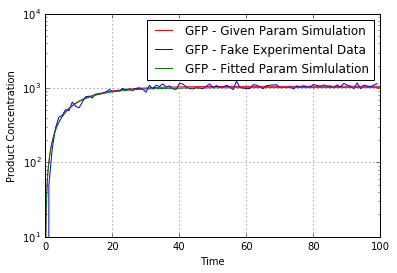

In [11]:
plt.plot(t, odeint(simulation_set_of_equations, init_P, t, args = tuple(params))[:,1], c='r', label='GFP - Given Param Simulation')
plt.plot(exp_t, exp_P[:,1], c='b', label='GFP - Fake Experimental Data')
plt.plot(t, odeint(simulation_set_of_equations, init_P, t, args = tuple(fitted_params))[:,1], c='g', label='GFP - Fitted Param Simlulation')
plt.legend(loc = 'best')
plt.xlabel('Time')
plt.ylabel('Product Concentration')
plt.grid()
plt.yscale('log')
plt.show()